# Neural Machine Translation with Attention

This approach follows <a href="https://arxiv.org/abs/1508.04025v5">this</a> paper and loosely follows the tutorial <a href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">here</a>. The dataset contains pairs of sentences in Spanish and their English translation.

## Imports

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from os import getcwd
import pathlib
import sys
import tensorflow as tf
import tensorflow_text as tf_text
import typing

path = pathlib.Path(getcwd())
p = str(path.parent.parent.parent.absolute())
if p not in sys.path:
    sys.path.append(p)

import custom_helper_functions as helper_functions

plt.style.use('dark_background')

## Loading the Dataset

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    extract=True,
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
)
path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inputs = [text_input for target, text_input in pairs]
    targets = [target for target, text_input in pairs]
    return targets, inputs

targets, inputs = load_data(path_to_file)

## Processing the Dataset

In [3]:
buffer_size = len(inputs)
batch_size = 64

ds = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(buffer_size)
ds = ds.batch(batch_size)

for example_batch, example_labels in ds.take(1):
    print(example_batch[:5])
    print(example_labels[:5])

def lower_and_split(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

vocab_size = 5000

input_text_processor = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size,
    standardize=lower_and_split
)
input_text_processor.adapt(inputs)

output_text_processor = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size,
    standardize=lower_and_split
)
output_text_processor.adapt(targets)

tf.Tensor(
[b'Tom es viejo.' b'Estudi\xc3\xa9 durante una hora.' b'Son cristianos.'
 b'A mi madre le encanta el t\xc3\xa9.' b'Tom lleg\xc3\xb3 ayer.'], shape=(5,), dtype=string)
tf.Tensor(
[b'Tom is old.' b'I studied for one hour.' b'They are Christians.'
 b'My mother likes tea very much.' b'Tom arrived yesterday.'], shape=(5,), dtype=string)


## Creating the Model

In [5]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super().__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        self.embedding = tf.keras.layers.Embedding(
            self.input_vocab_size,
            embedding_dim
        )
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            recurrent_initializer='glorot_uniform',
            return_sequences=True,
            return_state=True
        )

    def call(self, tokens, state=None):
        vectors = self.embedding(tokens)

        output, state = self.gru(vectors, initial_state=state)

        return output, state

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        w1_query = self.W1(query)
        w2_key = self.W2(value)

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True
        )

        return context_vector, attention_weights

class DecoderInput(typing.NamedTuple):
    new_tokens: typing.Any
    enc_output: typing.Any  
    mask: typing.Any

class DecoderOutput(typing.NamedTuple):
    logits: typing.Any
    attention_weights: typing.Any

class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super().__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = tf.keras.layers.Embedding(
            self.output_vocab_size,
            embedding_dim
        )
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            recurrent_initializer='glorot_uniform',
            return_sequences=True,
            return_state=True,
        )
        self.attention = BahdanauAttention(self.dec_units)
        self.Wc = tf.keras.layers.Dense(
            dec_units,
            activation=tf.math.tanh,
            use_bias=False
        )

        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

    def call(self, inputs, state=None):
        vectors = self.embedding(inputs.new_tokens)
        rnn_output, state = self.gru(vectors, initial_state=state)
        context_vector, attention_weights = self.attention(
            mask=inputs.mask,
            query=rnn_output,
            value=inputs.enc_output
        )
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
        attention_vector = self.Wc(context_and_rnn_output)
        logits = self.fc(attention_vector)
        return DecoderOutput(logits, attention_weights), state

class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction='none'
        )

    def __call__(self, y_true, y_pred):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(y_true!=0, tf.float32)
        loss *= mask

        return tf.reduce_sum(loss)

class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units, input_text_processor, output_text_processor, use_tf_function=True):
        super().__init__()
        encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function

    def _preprocess(self, input_text, target_text):
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)

        input_mask = input_tokens != 0
        target_mask = target_tokens != 0

        return input_tokens, input_mask, target_tokens, target_mask

    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:,0:1], new_tokens[:,1:2]
        decoder_input = DecoderInput(
            enc_output=enc_output,
            mask=input_mask,
            new_tokens=input_token
        )
        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state

    def _train_step(self, inputs):
        input_text, target_text = inputs

        (input_tokens, input_mask,
         target_tokens, target_mask) = self._preprocess(input_text, target_text)

        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            enc_output, enc_state = self.encoder(input_tokens)
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in range(max_target_length-1):
                new_tokens = target_tokens[:,t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask, enc_output, dec_state)
                loss = loss + step_loss

            average_loss = loss/tf.reduce_sum(tf.cast(target_mask, tf.float32))

        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        return {'batch_loss': average_loss}

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                                   tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

## Testing that the Model works Properly

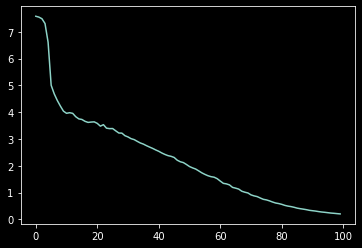

In [6]:
embedding_dim = 256
units = 1024
test_translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=True
)
test_translator.compile(
    loss=MaskedLoss(),
    optimizer=tf.optimizers.Adam()
)
 
losses = []
for n in range(100):
    logs = test_translator.train_step([example_batch, example_labels])
    losses.append(logs['batch_loss'].numpy())

plt.plot(losses)
plt.show()

## Training the Model

In [7]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        return self.logs.append(logs[self.key])

embedding_dim = 256
units = 1024

batch_loss = BatchLogs('batch_loss')
train_translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)
train_translator.compile(
    loss=MaskedLoss(),
    optimizer=tf.optimizers.Adam()
)
_ = train_translator.fit(ds, callbacks=[batch_loss], epochs=3)

Epoch 1/3
1859/1859 [==============================] - 623s 332ms/step - batch_loss: 2.0294
Epoch 2/3
1859/1859 [==============================] - 607s 327ms/step - batch_loss: 1.0399
Epoch 3/3
1859/1859 [==============================] - 599s 322ms/step - batch_loss: 0.8096


## Plotting Training Metrics

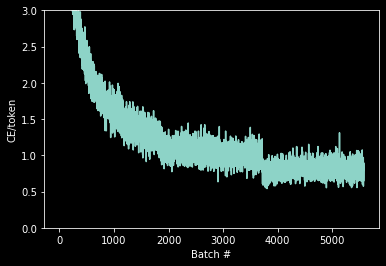

In [8]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')
plt.show()

## Completing the Translator

In [18]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.output_token_string_from_index = (
            tf.keras.layers.experimental.preprocessing.StringLookup(
                invert=True,
                mask_token='',
                vocabulary=output_text_processor.get_vocabulary()
            )
        )

        index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
            mask_token='',
            vocabulary=output_text_processor.get_vocabulary()
        )
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string('[START]')
        self.end_token = index_from_string('[END]')

    def sample(self, logits, temperature):
        logits = tf.where(self.token_mask, -np.inf, logits)
        
        if temperature == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else:
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(logits/temperature, num_samples=1)

        return new_tokens

    def tokens_to_text(self, result_tokens):
        result_text_tokens = self.output_token_string_from_index(result_tokens)
        result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=' ')
        result_text = tf.strings.strip(result_text)
        return result_text

    def translate(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        for _ in range(max_length):
            dec_input = DecoderInput(
                    enc_output=enc_output,
                    mask=(input_tokens!=0),
                    new_tokens=new_tokens
                )
            dec_result, dec_state = self.decoder(dec_input, state=dec_state)
            attention.append(dec_result.attention_weights)
            new_tokens = self.sample(dec_result.logits, temperature)

            done = done | (new_tokens == self.end_token)
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def tf_translate(self, input_text):
        return self.translate(input_text)

    def translate_symbolic(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)
        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)
        result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
        attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        for t in tf.range(max_length):
            dec_input = DecoderInput(
                enc_output=enc_output,
                mask=(input_tokens!=0),
                new_tokens=new_tokens
            )
            dec_result, dec_state = self.decoder(dec_input, state=dec_state)
            attention = attention.write(t, dec_result.attention_weights)
            new_tokens = self.sample(dec_result.logits, temperature)

            done = done | (new_tokens == self.end_token)
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
            result_tokens = result_tokens.write(t, new_tokens)

            if tf.reduce_all(done):
                break
        
        result_tokens = result_tokens.stack()
        result_tokens = tf.squeeze(result_tokens, -1)
        result_tokens = tf.transpose(result_tokens, [1, 0])
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = attention.stack()
            attention_stack = tf.squeeze(attention_stack, 2)
            attention_stack = tf.transpose(attention_stack, [1, 0, 2])
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def tf_translate_symbolic(self, input_text):
        return self.translate_symbolic(input_text)

translator = Translator(
    decoder=train_translator.decoder,
    encoder=train_translator.encoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)

## Testing the Translator and Visualizing Attention

<ipython-input-24-853be8144d9f>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-24-853be8144d9f>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


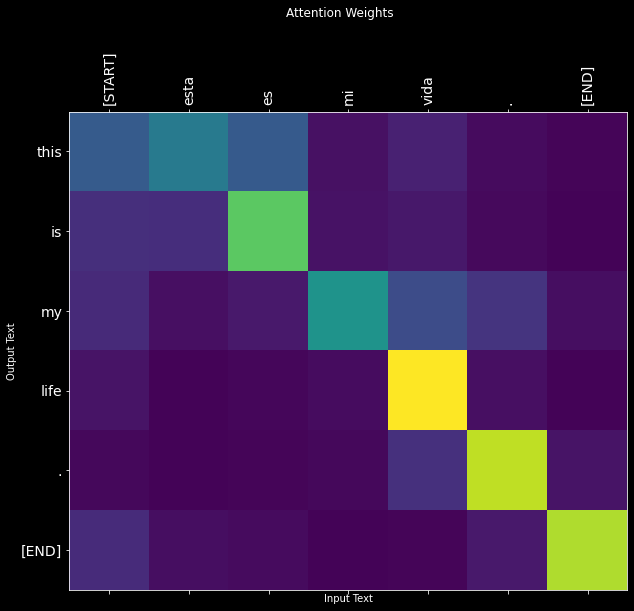

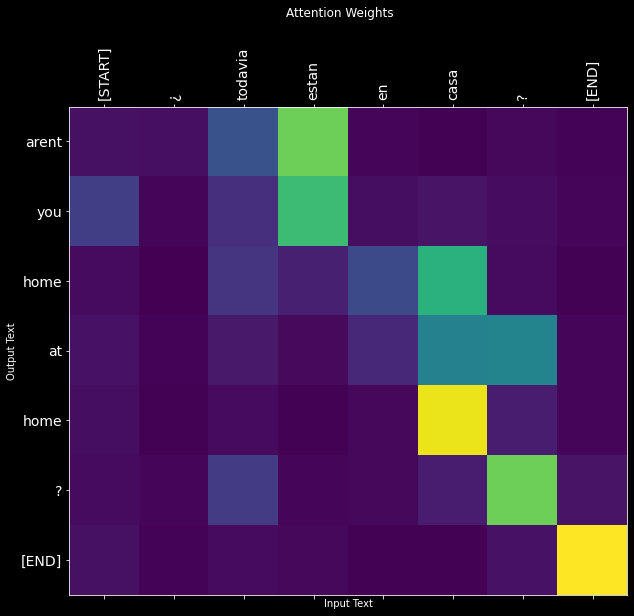

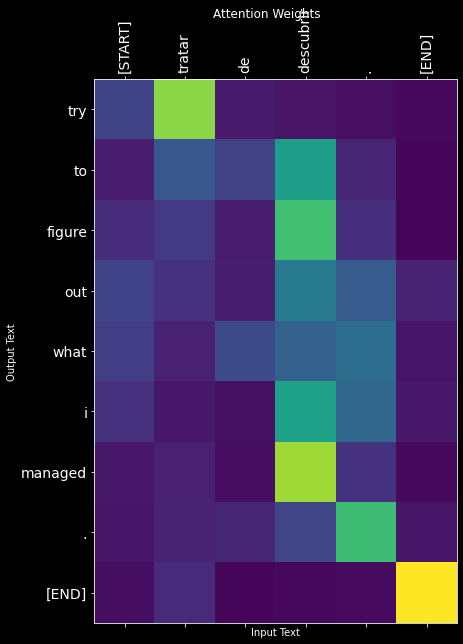

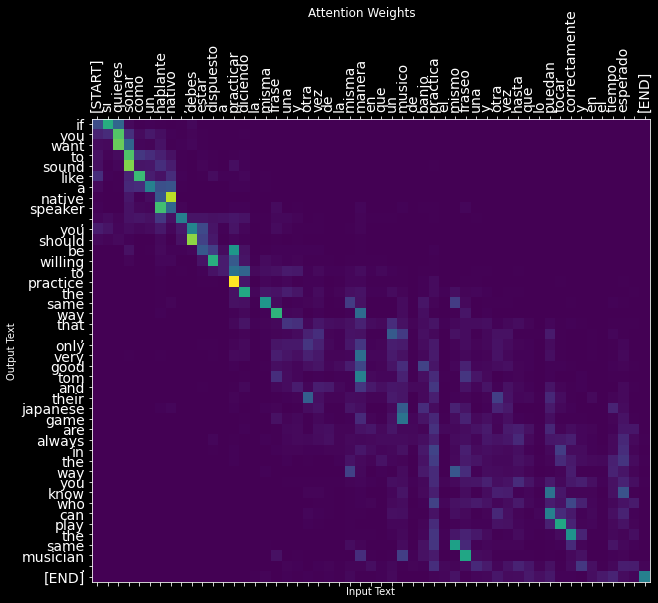

In [24]:
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])
result = translator.tf_translate_symbolic(three_input_text)

def plot_attention(attention, sentence, predicted_sentence):
    sentence = lower_and_split(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel('Input Text')
    ax.set_ylabel('Output Text')
    plt.suptitle('Attention Weights')
    plt.show()

for i in range(3):
    plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

long_input_text = tf.constant([inputs[-1]])
result = translator.tf_translate_symbolic(long_input_text)
i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])

The last figure never works since the model was trained with the correct input at each timestep (not the model's previous predictions) and the model only has access to the previous timestep through the RNN state. Both of these mean that the translator works well for short sentences but not for longer ones.

## Saving and Reloading the Model

In [26]:
tf.saved_model.save(translator, 'models\\translator', signatures={'serving_default': translator.tf_translate_symbolic})
reloaded = tf.saved_model.load('models\\translator') # To make sure everything worked properly


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: models\translator\assets


INFO:tensorflow:Assets written to: models\translator\assets
